In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import butter, filtfilt, spectrogram, iirnotch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import butter, filtfilt, spectrogram, iirnotch
import glob
import os
import sys
from scipy import signal
import matplotlib.pyplot as plt
from multiprocessing import Pool

import mne
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
from mne.io import concatenate_raws
from mne.io import concatenate_raws
from mne import Epochs, pick_types, events_from_annotations
from mne.preprocessing import create_ecg_epochs, create_eog_epochs, ICA
from mne.channels import read_layout

In [2]:
### File_name
file_run_1 = 'recording_eeg_1.csv'
file_run_2 = 'recording_eeg_2.csv'
file_run_3 = 'recording_eeg_3.csv'
file_run_4 = 'recording_eeg_4.csv'
file_run_5 = 'recording_eeg_5.csv'

In [3]:
### Read data from csv file.
colnames = [x for x in range(69)]
time_read = time.time()
raw_1 = pd.read_csv(file_run_1, names = colnames)
raw_2 = pd.read_csv(file_run_2, names = colnames)
raw_3 = pd.read_csv(file_run_3, names = colnames)
raw_4 = pd.read_csv(file_run_4, names = colnames)
raw_5 = pd.read_csv(file_run_5, names = colnames)
print('read time = ', time.time() - time_read)
raw_list = [raw_1, raw_2, raw_3, raw_4, raw_5]
time_delete = time.time()
for raw in raw_list:
    del raw[63]
print('deleted time = ', time.time() - time_delete)

read time =  40.680184841156006
deleted time =  1.6595959663391113


In [4]:
def gen_trial(trigger):
    count_trial = 0
    keep_trial = np.zeros(len(trigger))
    keep_trig = 3
    count_round = 0
    for trig_ar in np.array(trigger):
        trig = int(trig_ar)
        if trig == 3 and trig != keep_trig:
            count_trial += 1
        keep_trig = trig
        keep_trial[count_round] = count_trial
        count_round += 1
    return pd.DataFrame(keep_trial)

def insert_trial(raw_data, col_name):
    raw_trig = raw_data.loc[:, [68]]
    raw_trial = gen_trial(raw_trig)
    raw_data.insert(68, col_name, raw_trial)
    print("Length of trial = Length of data >>>> ", len(raw_trial) == len(raw_data))
    
def fil_data(raw_data, trial):
    fix_data = raw_data.loc[(raw_data[68] == 3) & (raw_data[69] == trial), 1:65]
    sit_data = raw_data.loc[(raw_data[68] == 4) & (raw_data[69] == trial), 1:65]
    stand_data = raw_data.loc[(raw_data[68] == 5) & (raw_data[69] == trial), 1:65]
    sit_status = raw_data.loc[(raw_data[68] == 4) & (raw_data[69] == trial), 68]
    ####Check state####
    if len(sit_status) == 0:
        #stand
        state = 1
        ####Check sampling####
        if stand_data.shape[0] < 4800:
            print('Stand data lost some sampling.', trial)
    else:
        #sit
        state = 0
        if sit_data.shape[0] < 4800:
            print('Sit data lost some sampling.', trial)

    
    return fix_data, sit_data, stand_data, state

def all_trial_in_dict(raw_data, type_data):
    state = np.zeros(40)
    all_fix = {}
    all_sit = {}
    all_stand = {}
    all_state = {}
    all_sit_stand = {}
    for i in range(1, 41):
        each_fix, each_sit, each_stand, status = fil_data(raw_data, i)
        all_stand.update({i:each_stand})
        all_sit.update({i:each_sit})
        all_fix.update({i:each_fix})
        state[i-1] = int(status)
        if int(status) == 0:
            all_sit_stand.update({i:each_sit})
        elif int(status) == 1:
            all_sit_stand.update({i:each_stand})
        if i == 40:
            all_state.update({'state':state.reshape(40, 1)})
    print('40 Trials finished.')
    if type_data == 'mr':
        return all_sit, all_stand, all_state
    elif type_data == 'mi':
        return all_sit_stand, all_state

def all_trial_in_array(raw_data, type_data):
    all_fix = np.zeros((40, 64, 3600))
    all_sit = np.zeros((20, 64, 4800))
    all_stand = np.zeros((20, 64, 4800))
    all_sit_stand = np.zeros((40, 64, 4800))
    all_fix_and_sit = np.zeros((20, 64, 8400))
    all_fix_and_stand = np.zeros((20, 64, 8400))
    all_state = np.zeros(40)
    sit_index = 0
    stand_index = 0
    for i in range(1, 41):
        each_fix, each_sit, each_stand, status = fil_data(raw_data, i)
        ## APPEND IN ARRAY ###
        if int(status) == 0:
            each_fix_and_sit = np.concatenate((each_fix, each_sit), axis=0)
            each_fix_and_sit = each_fix_and_sit[0:8400]
            each_fix = each_fix[0:3600]
            each_sit = each_sit[0:4800]
            all_sit[sit_index] = each_sit.T
            all_sit_stand[i-1] = each_sit.T
            all_fix_and_sit[sit_index] = each_fix_and_sit.T
            sit_index += 1
        else:
            each_fix_and_stand = np.concatenate((each_fix, each_stand), axis=0)
            each_fix_and_stand = each_fix_and_stand[0:8400]
            each_fix = each_fix[0:3600]
            each_stand = each_stand[0:4800]
            all_stand[stand_index] = each_stand.T
            all_sit_stand[i-1] = each_stand.T
            all_fix_and_stand[stand_index] = each_fix_and_stand.T
            stand_index += 1
        all_fix[i-1] = each_fix.T
        all_state[i-1] = int(status)
    print(i,'Trials finished.')
    if type_data == 'mr':
        return all_fix_and_sit, all_fix_and_stand, all_state
    elif type_data == 'mi':
        return all_sit_stand, all_state

def chk_array_data(data_1, data_2):
    pass
    count_round = 0
    for i in range(0, 20):
        if count_round == 0:
            print("-----------------Equality between data_1 and stand data_2 "+ str(i) +"-----------------")
            print(sit_data[i] == stand_data[i])
        else:
            print("-----------------Equality between data_1 and stand data_2 "+ str(i) +"-----------------")
            print(sit_data[i] == stand_data[i])
            print("-----------------Equality between trial "+str(i)+' and '+str(i-1)+"-----------------")
            print("-----DATA_1-----")
            print(sit_data[i] == sit_data[i-1])
            print("-----DATA_2-----")
            print(stand_data[i] == stand_data[i-1])
        count_round += 1
        
def all_run_data(data_run_1, data_run_2, data_run_3, data_run_4, data_run_5):
    all_run_data_arr = np.concatenate((data_run_1, data_run_2, data_run_3, data_run_4, data_run_5), axis=0)
    print('Finished !', all_run_data_arr.shape)
    return all_run_data_arr
    
def cut_data_from_onset():
    pass

def preprocess_all_trial():
    pass
    
def t_d(data, duration):
    len_data = len(data)
    samples = []
    for i in range(0, len_data, duration):
        sample = data.values[i:i + duration]
        samples.append(sample)
    array_data = np.array(samples)
    return array_data

# INSERT TRIAL COLUMN

In [5]:
insert_trial(raw_1, 69)
insert_trial(raw_2, 69)
insert_trial(raw_3, 69)
insert_trial(raw_4, 69)
insert_trial(raw_5, 69)

Length of trial = Length of data >>>>  True
Length of trial = Length of data >>>>  True
Length of trial = Length of data >>>>  True
Length of trial = Length of data >>>>  True
Length of trial = Length of data >>>>  True


#  SHAPE DATA

In [6]:
sit_and_fix_1, stand_and_fix_1, state_1 = all_trial_in_array(raw_1, 'mr')
sit_and_fix_2, stand_and_fix_2, state_2 = all_trial_in_array(raw_2, 'mr')
sit_and_fix_3, stand_and_fix_3, state_3 = all_trial_in_array(raw_3, 'mr')
sit_and_fix_4, stand_and_fix_4, state_4 = all_trial_in_array(raw_4, 'mr')
sit_and_fix_5, stand_and_fix_5, state_5 = all_trial_in_array(raw_5, 'mr')

40 Trials finished.
40 Trials finished.
40 Trials finished.
40 Trials finished.
40 Trials finished.


# ALL RUN DATA

In [7]:
sit_and_fix = all_run_data(sit_and_fix_1, sit_and_fix_2, sit_and_fix_3, sit_and_fix_4, sit_and_fix_5)
stand_and_fix = all_run_data(stand_and_fix_1, stand_and_fix_2, stand_and_fix_3, stand_and_fix_4, stand_and_fix_5)

Finished ! (100, 64, 8400)
Finished ! (100, 64, 8400)


# FILTER AND ICA

In [8]:
ch_names = ["AFz", "Fz", "Fp1", "Fp2", "AF7", "AF5", "AF3", "AF4", "AF6", "AF8", "F7", 
            "F5", "F3", "F1", "F2", "F4", "F6", "F8", "FT7", "FC5", "FC3", "FC1", "FCz", 
            "FC2", "FC4", "FC6", "FT8", "T7", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", 
            "T8","TP7", "CP5", "CP3", "CP1", "CPz", "CP2", "CP4", "CP6", "TP8", "P7", 
            "P5", "P3", "P1", "Pz", "P2", "P4", "P6", "P8", "PO7", "PO3", "POz", "PO4", 
            "PO8", "O1", "Oz", "O2"]
ch_eogs = ["VEOG", "HEOG"]
ch_names_all = ch_names+ch_eogs
smp_freq = 1200
print(len(ch_names))

62


In [9]:
# Preprocessing
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y
def notch_filter(data, f0, fs, Q): # Q = Quality factor
    w0 = f0/(fs/2)
    b, a = iirnotch(w0, Q)
    y = filtfilt(b, a, data)
    return y
def preprocessing(data):
    """Preprocessing time-dimain EEG raw data

    Parameters
    ----------
    data : EEG time-domain raw data 

    Returns
    ----------
    filtered : filtered EEG time-domain raw data 
    """
    filtered = notch_filter(data, 50, smp_freq, 25)
    filtered = butter_bandpass_filter(filtered, 0.05, 40, smp_freq, 2)
    print('notch_filter 50 Hz .... bandpass 0.05-40 Hz.')
    return filtered

In [10]:
def calulate_ICA(arr, save_name='SUB_01', threshold=2):
    """
    Parameters
    ----------
    arr : output from collect_data_allphase
    save_name : figure name, keep none if no need to save
    return:
        arr liked array with EOG removal
    """
    if save_name is not None:
        for directory in ['ica','eog_score','eog_avg','raw_EEG','corrected_EEG','montage','new_raw']:
            if not os.path.exists(directory):
                os.makedirs(directory)

    # Create a dummy mne.io.RawArray object
#     ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eog', 'eog']
    ch_names = ["AFz", "Fz", "Fp1", "Fp2", "AF7", "AF5", "AF3", "AF4", "AF6", "AF8", "F7", 
            "F5", "F3", "F1", "F2", "F4", "F6", "F8", "FT7", "FC5", "FC3", "FC1", "FCz", 
            "FC2", "FC4", "FC6", "FT8", "T7", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", 
            "T8","TP7", "CP5", "CP3", "CP1", "CPz", "CP2", "CP4", "CP6", "TP8", "P7", 
            "P5", "P3", "P1", "Pz", "P2", "P4", "P6", "P8", "PO7", "PO3", "POz", "PO4", 
            "PO8", "O1", "Oz", "O2"]
    ch_eogs = ["VEOG", "HEOG"]
    ch_names_all = ch_names+ch_eogs
    ch_types = ['eeg' for i in range(len(ch_names))] + ['eog', 'eog']
    # Create an info object.
    info = mne.create_info(ch_names=ch_names_all, sfreq=smp_freq, ch_types=ch_types)
    raw = mne.io.RawArray(arr, info)
    raw.set_montage("standard_1020")
    
    ica = ICA(method = "fastica", random_state=42)
    ica.fit(raw)

    n_max_eog =  5  # use max 3 components
    eog_epochs = create_eog_epochs(raw)
    eog_epochs.apply_baseline((None, None))

    try:
        print('debug !')
        eog_inds, scores_eog = ica.find_bads_eog(eog_epochs,threshold=threshold)
        print('Found %d EOG component(s)' % (len(eog_inds),))

        #remove EOG from EEG
        ica.exclude += eog_inds
    except:
        pass
    print('debug !')
    raw_corrected = raw
    ica.apply(raw_corrected)
    print(ica)

    # #plot
#     if save_name is not None:
#         print('debug !')
#         ica.plot_sources(raw, show = False).savefig('ica/'+save_name+'_ica.png') 
#         try:
#             ica.plot_scores(scores_eog, exclude=eog_inds, title='EOG scores',show = False).savefig('eog_score/'+save_name+'_eog_score.png') 
#         except:
#             pass
#         scalings = 'auto'
#         ica.plot_sources(eog_epochs.average(), title='EOG average',show = False).savefig('eog_avg/'+save_name+'_eog_avg.png')
#         raw.plot(show = False,scalings=scalings).savefig('raw_EEG/'+save_name+'_raw_EEG.png')
#         raw_corrected.plot(show = False,scalings=scalings).savefig('corrected_EEG/'+save_name+'_corrected_EEG.png')
#         ica.plot_components(inst=raw, show = False)[0].savefig('montage/'+save_name+'_montage.png')
#         print('======================================')
#         print(raw_corrected.get_data().shape)
#         raw_corrected.save('new_raw/'+save_name+'_raw.fif', overwrite=True)
    return raw_corrected

# PREPROCESS ALL TRIAL

In [11]:
sit_and_fix_pre = np.zeros(sit_and_fix.shape)
stand_and_fix_pre = np.zeros(stand_and_fix.shape)
for i in range(sit_and_fix.shape[0]):
    sit_and_fix_pre[i, :, :] = preprocessing(sit_and_fix[i, :, :])
    stand_and_fix_pre[i, :, :] = preprocessing(stand_and_fix[i, :, :])

notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filt

notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.
notch_filter 50 Hz .... bandpass 0.05-40 Hz.


In [12]:
print(sit_and_fix_pre.shape)
print(stand_and_fix_pre.shape)

(100, 64, 8400)
(100, 64, 8400)


# ICA ALL TRIAL

# SIT

In [13]:
sit_and_fix_pre_eog_car_avg = np.zeros(sit_and_fix_pre.shape)
for f in range(sit_and_fix_pre.shape[0]):
    sit_and_fix_pre_eog_removal = calulate_ICA(sit_and_fix_pre[f])
    sit_and_fix_pre_eog_removal.filter(l_freq=0.1, h_freq=3, method="iir")
    sit_and_fix_pre_eog_removal.del_proj()
    sit_and_fix_pre_raw_car, _ = mne.set_eeg_reference(sit_and_fix_pre_eog_removal, 'average', projection=True)
    sit_and_fix_pre_eog_car_avg[f, :, :] = sit_and_fix_pre_raw_car[:][0]
    print(sit_and_fix_pre_eog_car_avg.shape)

Creating RawArray with float64 data, n_channels=64, n_times=8400
    Range : 0 ... 8399 =      0.000 ...     6.999 secs
Ready.
DigMontage is a superset of info. 32 in DigMontage will be ignored. The ignored channels are: {'P10', 'AF9', 'FT10', 'PO9', 'T6', 'FT9', 'PO1', 'PO6', 'PO5', 'F9', 'T9', 'AF10', 'TP10', 'P9', 'M2', 'T4', 'T10', 'T3', 'M1', 'T5', 'PO2', 'TP9', 'A2', 'O9', 'AF1', 'AF2', 'Fpz', 'A1', 'O10', 'PO10', 'F10', 'Iz'}
Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 3.5s.
EOG channel index for this subject is: [62 63]
Filtering the data to remove DC offset to help distinguish blinks from saccades


C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 12 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 12 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 12 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 6 significant peaks
Number of EOG events detected : 6
6 matching events found
No baseline correction applied
Not setting metadata
Loading data for 6 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 13 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 13 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 13 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 13 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 13 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 13 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 15 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 15 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 15 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 12 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 12 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 12 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 12 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 12 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 12 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 13 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 13 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 13 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 12 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 12 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 12 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 12 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 12 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 12 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 5 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 5 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 5 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 6 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 6 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 6 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 2 significant peaks
Number of EOG events detected : 2
2 matching events found
No baseline correction applied
Not setting metadata
Loading data for 2 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 6 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 6 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 6 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 2 significant peaks
Number of EOG events detected : 2
2 matching events found
No baseline correction applied
Not setting metadata
Loading data for 2 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 6 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 6 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 6 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 2 significant peaks
Number of EOG events detected : 2
2 matching events found
No baseline correction applied
Not setting metadata
Loading data for 2 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 2 significant peaks
Number of EOG events detected : 2
2 matching events found
No baseline correction applied
Not setting metadata
Loading data for 2 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 4 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 4 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 4 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
2 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 5 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 5 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 5 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 5 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 5 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 5 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 12 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 12 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 12 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 6 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 6 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 6 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 6 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 6 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 6 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 6 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 6 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 6 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

# STAND

In [14]:
stand_and_fix_pre_eog_car_avg = np.zeros(stand_and_fix_pre.shape)
for m in range(stand_and_fix_pre.shape[0]):
    stand_and_fix_pre_eog_removal = calulate_ICA(stand_and_fix_pre[m])
    stand_and_fix_pre_eog_removal.filter(l_freq=0.1, h_freq=3, method="iir")
    stand_and_fix_pre_eog_removal.del_proj()
    stand_and_fix_pre_raw_car, _ = mne.set_eeg_reference(stand_and_fix_pre_eog_removal, 'average', projection=True)
    stand_and_fix_pre_eog_car_avg[m, :, :] = stand_and_fix_pre_raw_car[:][0]
    print(stand_and_fix_pre_eog_car_avg.shape)

Creating RawArray with float64 data, n_channels=64, n_times=8400
    Range : 0 ... 8399 =      0.000 ...     6.999 secs
Ready.
DigMontage is a superset of info. 32 in DigMontage will be ignored. The ignored channels are: {'P10', 'AF9', 'FT10', 'PO9', 'T6', 'FT9', 'PO1', 'PO6', 'PO5', 'F9', 'T9', 'AF10', 'TP10', 'P9', 'M2', 'T4', 'T10', 'T3', 'M1', 'T5', 'PO2', 'TP9', 'A2', 'O9', 'AF1', 'AF2', 'Fpz', 'A1', 'O10', 'PO10', 'F10', 'Iz'}
Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 62
Fitting ICA took 2.6s.
EOG channel index for this subject is: [62 63]
Filtering the data to remove DC offset to help distinguish blinks from saccades


<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
2 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 5 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 5 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 5 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 5 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 5 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 5 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 6 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 6 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 6 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 12 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 12 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 12 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 2 significant peaks
Number of EOG events detected : 2
2 matching events found
No baseline correction applied
Not setting metadata
Loading data for 2 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 6 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 6 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 6 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 6 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 6 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 6 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 12 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 12 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 12 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 4 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 4 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 4 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
2 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
5 matching events found
No baseline correction applied
Not setting metadata
Loading data for 5 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 12 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 12 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 12 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 2 significant peaks
Number of EOG events detected : 2
2 matching events found
No baseline correction applied
Not setting metadata
Loading data for 2 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 2 significant peaks
Number of EOG events detected : 2
2 matching events found
No baseline correction applied
Not setting metadata
Loading data for 2 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 2 significant peaks
Number of EOG events detected : 2
2 matching events found
No baseline correction applied
Not setting metadata
Loading data for 2 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 2 significant peaks
Number of EOG events detected : 2
2 matching events found
No baseline correction applied
Not setting metadata
Loading data for 2 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 2 significant peaks
Number of EOG events detected : 2
2 matching events found
No baseline correction applied
Not setting metadata
Loading data for 2 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 6 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 6 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 6 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 2 significant peaks
Number of EOG events detected : 2
2 matching events found
No baseline correction applied
Not setting metadata
Loading data for 2 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 6 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 6 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 6 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 10 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 10 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 10 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

C:\Program Files\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 9 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 9 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 9 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 6 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 6 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 6 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 7 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 7 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 7 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected : 4
4 matching events found
No baseline correction applied
Not setting metadata
Loading data for 4 events and 1201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 8 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 8 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 8 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been

<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)
<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (13.653 sec)



<ipython-input-10-7155c945948d>:35: RuntimeWarning: filter_length (16384) is longer than the signal (8400), distortion is likely. Reduce filter length or filter a longer signal.
  eog_epochs = create_eog_epochs(raw)


Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
3 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3 events and 1201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
debug !
Found 11 EOG component(s)
debug !
Transforming to ICA space (62 components)
Zeroing out 11 ICA components
<ICA  |  raw data decomposition, fit (fastica): 8400 samples, 62 components, channels used: "eeg", 11 sources marked for exclusion>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 3.00 Hz: -6.02, -6.02 dB

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not b

# RECEIVE ONSET POINT FROM EMG DATA

In [15]:
sit_onset = np.load('sit_onset.npy')
stand_onset = np.load('stand_onset.npy')
sit_onset_mean = np.nanmean(sit_onset, axis=1)
stand_onset_mean = np.nanmean(stand_onset, axis=1)

# CUT DATA FROM ONSET POINT

In [17]:
########### SIT ##############
sit_onset_data = np.zeros((100, 64, 2400))
for idx_sit, all_data in enumerate(sit_and_fix_pre_eog_car_avg):
    start_point = 3600 + int(sit_onset_mean[idx_sit].round()) - 1800
    stop_point = start_point + 2400
    sit_onset_data[idx_sit, :, :] = all_data[:, start_point:stop_point]

In [18]:
########## STAND ###############
stand_onset_data = np.zeros((100, 64, 2400))
for idx_stand, all_data_stand in enumerate(stand_and_fix_pre_eog_car_avg):
    start_point_stand = 3600 + int(stand_onset_mean[idx_stand].round()) - 1800
    stop_point_stand = start_point_stand + 2400
    stand_onset_data[idx_stand, :, :] = all_data_stand[:, start_point_stand:stop_point_stand]

# PLOT AVG ALL RUN

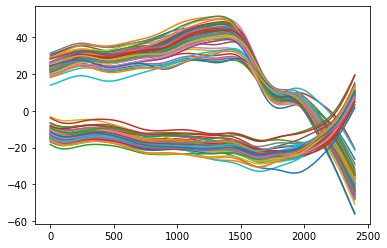

In [19]:
##### SIT ######
sit_mean_1 = sit_onset_data[0:20].mean(axis=0)
for i in range(62):
    plt.plot(sit_mean_1[i, :])
    
##### STAND #####
stand_mean_1 = stand_onset_data[0:20].mean(axis=0)
for o in range(62):
    plt.plot(stand_mean_1[o, :])

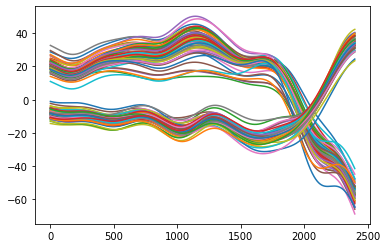

In [20]:
##### SIT ######
sit_mean_2 = sit_onset_data[20:40].mean(axis=0)
for i in range(62):
    plt.plot(sit_mean_2[i, :])
    
##### STAND #####
stand_mean_2 = stand_onset_data[20:40].mean(axis=0)
for o in range(62):
    plt.plot(stand_mean_2[o, :])

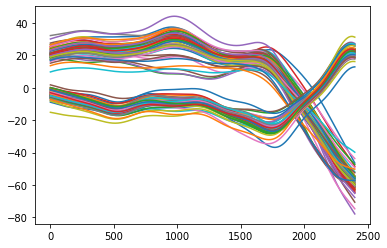

In [21]:
##### SIT ######
sit_mean_3 = sit_onset_data[40:60].mean(axis=0)
for i in range(62):
    plt.plot(sit_mean_3[i, :])
    
##### STAND #####
stand_mean_3 = stand_onset_data[40:60].mean(axis=0)
for o in range(62):
    plt.plot(stand_mean_3[o, :])

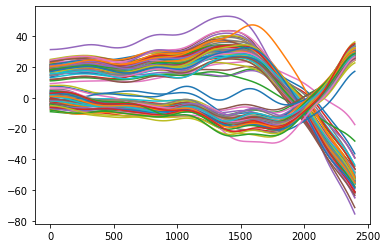

In [22]:
##### SIT ######
sit_mean_4 = sit_onset_data[60:80].mean(axis=0)
for i in range(62):
    plt.plot(sit_mean_4[i, :])
    
##### STAND #####
stand_mean_4 = stand_onset_data[60:80].mean(axis=0)
for o in range(62):
    plt.plot(stand_mean_4[o, :])

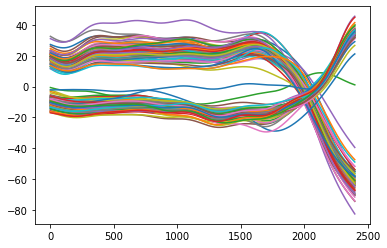

In [23]:
##### SIT ######
sit_mean_5 = sit_onset_data[80:100].mean(axis=0)
for i in range(62):
    plt.plot(sit_mean_5[i, :])
    
##### STAND #####
stand_mean_5 = stand_onset_data[80:100].mean(axis=0)
for o in range(62):
    plt.plot(stand_mean_5[o, :])